In [1]:
# ==============================================================================
# 模块一：环境准备与数据加载
# ==============================================================================
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from chinese_calendar import is_workday, is_holiday
from functools import partial
import json
import matplotlib.pyplot as plt
import seaborn as sns

# -- 配置绘图风格和中文显示 --
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# --- 1. 定义文件路径 ---
panel_data_path = r"E:\A智网\电量预测数据\lightgbm模型\133个行业电量与天气对齐数据_0815.csv"
full_weather_path = r"E:\A智网\电量预测数据\lightgbm模型\湖北省每日温度特征.xlsx"

# --- 2. 加载【历史】电量与天气面板数据 ---
try:
    print("--- 正在加载历史电量与天气面板数据 ---")
    df_main = pd.read_csv(panel_data_path, parse_dates=['date'], encoding='gbk')
    print("历史面板数据加载成功！")
    print("数据预览：")
    print(df_main.head())
except Exception as e:
    print(f"加载面板数据时出错: {e}")
    df_main = pd.DataFrame()

# --- 3. 加载并准备【完整天气】数据源 ---
try:
    print("\n--- 正在加载完整天气数据源 ---")
    df_weather_raw = pd.read_excel(full_weather_path)
    df_weather_full = df_weather_raw.set_index('温度特征').T
    df_weather_full.index.name = 'date'
    df_weather_full.index = pd.to_datetime(df_weather_full.index, format='%Y%m%d')
    df_weather_full.rename(columns={
        '日平均温度': 'temp_mean', '日最高温度': 'temp_max', '日最低温度': 'temp_min',
        '日温度标准差': 'temp_std', '日温差': 'temp_range'
    }, inplace=True)
    print("完整天气数据源加载成功！")
except Exception as e:
    print(f"加载完整天气数据时出错: {e}")
    df_weather_full = pd.DataFrame()

--- 正在加载历史电量与天气面板数据 ---
历史面板数据加载成功！
数据预览：
        行业名称       date    load_MWh  temp_mean  temp_max  temp_min  temp_std  \
0      客户用电量 2023-01-01  56822.2209      6.883     8.776     5.495      1.09   
1  A、全行业用电合计 2023-01-01  39712.4177      6.883     8.776     5.495      1.09   
2       第一产业 2023-01-01    811.9297      6.883     8.776     5.495      1.09   
3       第二产业 2023-01-01  25598.1050      6.883     8.776     5.495      1.09   
4       第三产业 2023-01-01  13302.3830      6.883     8.776     5.495      1.09   

   temp_range  
0       3.281  
1       3.281  
2       3.281  
3       3.281  
4       3.281  

--- 正在加载完整天气数据源 ---
完整天气数据源加载成功！


In [2]:
# ==============================================================================
# 模块二：在工作日数据上进行滚动窗口异常检测
# 输入: df_main
# 输出: df_main (增加了'is_outlier'列)
# ==============================================================================
def flag_outliers_on_workdays(df, industry_col='行业名称', value_col='load_MWh', date_col='date', window_size=31, factor=2.5):
    print("\n" + "="*50)
    print("      开始执行：工作日滚动窗口异常检测")
    print("="*50)
    df_flagged = df.copy()
    df_flagged['is_outlier'] = 0
    workday_mask = df_flagged[date_col].apply(is_workday)
    industries = df_flagged[industry_col].unique()
    total_outliers_found = 0
    for industry in industries:
        industry_workday_mask = (df_flagged[industry_col] == industry) & workday_mask
        series = df_flagged.loc[industry_workday_mask, value_col]
        if len(series) < 20: continue
        rolling_q1 = series.rolling(window=window_size, center=True, min_periods=window_size//2).quantile(0.25)
        rolling_q3 = series.rolling(window=window_size, center=True, min_periods=window_size//2).quantile(0.75)
        rolling_iqr = rolling_q3 - rolling_q1
        lower_bound = rolling_q1 - (rolling_iqr * factor)
        upper_bound = rolling_q3 + (rolling_iqr * factor)
        outlier_mask = (series < lower_bound) | (series > upper_bound)
        outlier_indices = series[outlier_mask].index
        df_flagged.loc[outlier_indices, 'is_outlier'] = 1
        total_outliers_found += outlier_mask.sum()
    print(f"\n处理完成！总共在【工作日】数据中标记了 {total_outliers_found} 个统计异常点。")
    return df_flagged

if 'df_main' in locals() and not df_main.empty:
    df_main = flag_outliers_on_workdays(df_main)
    print("主DataFrame 'df_main' 已被添加了'is_outlier'特征的数据覆盖。")
else:
    print("错误：'df_main' 未加载，无法进行异常处理。")


      开始执行：工作日滚动窗口异常检测

处理完成！总共在【工作日】数据中标记了 582 个统计异常点。
主DataFrame 'df_main' 已被添加了'is_outlier'特征的数据覆盖。


In [3]:
# ==============================================================================
# 模块三：严格的时序划分 (在特征工程之前)
# 输入: df_main
# 输出: historical_df, test_df
# ==============================================================================
if 'df_main' in locals() and not df_main.empty:
    test_start_date = df_main['date'].max() - pd.DateOffset(days=29)
    
    historical_df = df_main[df_main['date'] < test_start_date].copy()
    test_df = df_main[df_main['date'] >= test_start_date].copy()

    print("\n--- 数据集已严格划分为历史集和测试集 ---")
    print(f"  历史数据 (historical_df): {len(historical_df)} 行, 截止到 {historical_df['date'].max().date()}")
    print(f"  最终测试集 (test_df): {len(test_df)} 行, 从 {test_start_date.date()} 开始")
else:
    print("错误：'df_main' 未加载，无法进行数据划分。")


--- 数据集已严格划分为历史集和测试集 ---
  历史数据 (historical_df): 124352 行, 截止到 2025-07-16
  最终测试集 (test_df): 4020 行, 从 2025-07-17 开始


In [14]:
# =' '=============================================================================
# 模块四 & 五 (最终版 - 恢复真实未来天气): 特征工程、敏感度分析与模型分层
# ==============================================================================

# --- 4a. 定义【终极版】特征工程函数 (逻辑重构，不再使用set_index) ---
def create_panel_features_ultimate(df_input, df_weather_source):
    """
    终极版特征工程函数 (恢复使用真实的未来天气数据)
    警告：此函数使用了未来的真实数据(shift(-N))，用于探索模型性能上限。
    此函数期望输入的 df_input 中已经包含了 'sensitivity' 列。
    """
    print("\n--- 正在执行终极版特征工程 (使用真实未来天气) ---")
    
    df_proc = df_input.copy()
    
    # --- 1. 创建基础特征 (与你的版本完全一致) ---
    df_proc = df_proc.sort_values(by=['行业名称', 'date']).reset_index(drop=True)
    print("正在创建历史和日历相关特征...")
    df_proc['month'] = df_proc['date'].dt.month
    df_proc['dayofweek'] = df_proc['date'].dt.dayofweek
    df_proc['dayofyear'] = df_proc['date'].dt.dayofyear
    df_proc['weekofyear'] = df_proc['date'].dt.isocalendar().week.astype(int)
    df_proc['is_holiday'] = df_proc['date'].apply(is_holiday).astype(int)
    df_proc['is_weekend_norm'] = (df_proc['date'].dt.dayofweek >= 5).astype(int)
    df_proc['is_adj_workday'] = df_proc.apply(lambda row: 1 if is_workday(row['date']) and row['dayofweek'] >= 5 else 0, axis=1)
    df_proc['is_offday'] = df_proc.apply(lambda row: 1 if row['is_holiday'] == 1 or (row['is_weekend_norm'] == 1 and row['is_adj_workday'] == 0) else 0, axis=1)
    lags = [1, 2, 7, 14]
    for lag in lags:
        df_proc[f'load_lag_{lag}'] = df_proc.groupby('行业名称')['load_MWh'].shift(lag)
    df_proc['rolling_mean_7'] = df_proc.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).mean()
    df_proc['rolling_std_7'] = df_proc.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).std()
    df_proc['load_diff_1_7'] = df_proc['load_lag_1'] - df_proc['load_lag_7']
    df_proc['load_ratio_1_roll7'] = (df_proc['load_lag_1'] / (df_proc['rolling_mean_7'] + 1e-6)) - 1
    
    # --- 2. 【核心恢复】使用 shift(-N) 和 merge 创建【真实】未来天气特征 ---
    print("正在创建【交互式】的真实未来天气特征...")
    
    future_days = [1, 2, 3]
    weather_cols = ['temp_max', 'temp_min', 'temp_mean']
    
    # a) 准备包含所有未来天气的临时天气表
    df_weather_features_to_add = df_weather_source[weather_cols].copy()
    for day in future_days:
        for col in weather_cols:
            df_weather_features_to_add[f'{col}_future_d{day}'] = df_weather_source[col].shift(-day)
            
    # b) 将这个准备好的天气特征表，合并到主数据中
    df_proc = pd.merge(df_proc, df_weather_features_to_add.reset_index(), on='date', how='left')
    
    # c) 在合并之后，再创建交互特征
    if 'sensitivity' not in df_proc.columns:
        raise ValueError("错误: 输入的DataFrame中必须包含 'sensitivity' 列才能创建交互特征！")
        
    for day in future_days:
        for col in weather_cols:
            future_col = f'{col}_future_d{day}'
            df_proc[f'{future_col}_high_sens'] = df_proc[future_col] * (df_proc['sensitivity'] == '高敏感')
            df_proc[f'{future_col}_low_sens'] = df_proc[future_col] * (df_proc['sensitivity'] == '低敏感')
            df_proc = df_proc.drop(columns=[future_col])

    print("交互式未来天气特征创建完成！")

    # --- 3. 清理与返回 ---
    df_proc['行业名称'] = df_proc['行业名称'].astype('category')
    df_proc = df_proc.drop(['is_weekend_norm', 'is_adj_workday'], axis=1)
    
    return df_proc

# --- 5a. 在【纯净历史数据】上进行天气敏感度分析 ---
if 'historical_df' in locals():
    # 【强化】主动清理任何残留的sensitivity列，防止重复运行时出错
    cols_to_drop = ['sensitivity', 'sensitivity_x', 'sensitivity_y']
    for col in cols_to_drop:
        if col in historical_df.columns:
            historical_df = historical_df.drop(columns=[col])
            print(f"检测到并移除了残留的 '{col}' 列。")

    print("\n--- 正在【纯净历史数据】上进行天气敏感度分析 ---")
    correlations = historical_df.groupby('行业名称')[['load_MWh', 'temp_max']].corr().unstack().iloc[:, 1]
    def assign_sensitivity(corr_value):
        if corr_value is not None and corr_value > 0.4: return '高敏感'
        else: return '低敏感'
    sensitivity_df = correlations.to_frame('correlation')
    sensitivity_df['sensitivity'] = sensitivity_df['correlation'].apply(assign_sensitivity)
    
    # --- 5b. 【核心】为 historical_df 添加敏感度标签 ---
    historical_df = pd.merge(historical_df, sensitivity_df[['sensitivity']], left_on='行业名称', right_index=True, how='left')
    historical_df['sensitivity'] = historical_df['sensitivity'].fillna('低敏感')
    print("天气敏感度分析完成，并已将标签添加到historical_df。")
else:
    print("错误：'historical_df'不存在，无法进行敏感度分析。")

# --- 5c. 【核心】对【添加了敏感度标签】的历史数据，进行终极版特征工程 ---
if 'historical_df' in locals() and 'df_weather_full' in locals():
    # 严格使用你已有的函数名和变量名
    df_featured_historical = create_panel_features_ultimate(historical_df, df_weather_full)
    
    # 在特征工程后，再把不再需要的 sensitivity 列删掉
    if 'sensitivity' in df_featured_historical.columns:
        df_featured_historical = df_featured_historical.drop(columns=['sensitivity'])
        
    df_featured_historical = df_featured_historical.dropna()
else:
    print("错误：缺少必要数据，无法进行特征工程。")

# --- 5d. 在【特征化后】的历史数据上进行模型分层 ---
if 'df_featured_historical' in locals():
    print("\n--- 正在进行模型分层 ---")
    # 使用原始的 historical_df 计算均值，避免特征工程的影响
    industry_avg_load = historical_df.groupby('行业名称')['load_MWh'].mean().to_frame('avg_load')
    def assign_tier(avg_load):
        if avg_load >= 1000: return '大行业'
        elif avg_load < 100: return '小行业'
        else: return '中行业'
    industry_avg_load['tier'] = industry_avg_load['avg_load'].apply(assign_tier)
    df_featured_historical = pd.merge(df_featured_historical, industry_avg_load[['tier']], on='行业名称', how='left')
    df_featured_historical['tier'] = df_featured_historical['tier'].fillna('小行业')

    # --- 5e. 创建最终用于训练和调优的分层字典 ---
    data_tiers_hist = {
        '大行业': df_featured_historical[df_featured_historical['tier'] == '大行业'].copy(),
        '中行业': df_featured_historical[df_featured_historical['tier'] == '中行业'].copy(),
        '小行业': df_featured_historical[df_featured_historical['tier'] == '小行业'].copy()
    }
    print("分层数据集 'data_tiers_hist' 创建成功！")
else:
    print("错误：'df_featured_historical'不存在，无法进行模型分层。")

检测到并移除了残留的 'sensitivity' 列。

--- 正在【纯净历史数据】上进行天气敏感度分析 ---
天气敏感度分析完成，并已将标签添加到historical_df。

--- 正在执行终极版特征工程 (使用真实未来天气) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！

--- 正在进行模型分层 ---
分层数据集 'data_tiers_hist' 创建成功！


In [5]:
# ==============================================================================
# 模块六：为三个分层模型分别进行超参数调优
# 输入: data_tiers_hist (字典)
# 输出: best_params_per_tier (字典)
# ==============================================================================
best_params_per_tier = {}
if 'data_tiers_hist' in locals() and data_tiers_hist:
    print("\n" + "="*50)
    print("      开始为三个层级的模型进行自动化超参数调优")
    print("="*50)
    def objective(trial, X_train, y_train, X_val, y_val):
        X_train['行业名称'] = X_train['行业名称'].astype('category')
        X_val['行业名称'] = X_val['行业名称'].astype('category')
        params = {
            'objective': 'regression_l1', 'metric': 'l1', 'n_estimators': 3000,
            'random_state': 42, 'n_jobs': -1, 'verbosity': -1,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 200),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 80),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        }
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)], eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)],
                  categorical_feature=['行业名称'])
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        return mae

    for tier_name, df_tier in data_tiers_hist.items():
        if df_tier.empty: continue
        print(f"\n--- 正在为【{tier_name}】模型寻找最优参数 ---")
        val_date_start = df_tier['date'].max() - pd.DateOffset(days=59)
        train_df = df_tier[df_tier['date'] < val_date_start].copy()
        val_df = df_tier[df_tier['date'] >= val_date_start].copy()
        FEATURES = [col for col in df_tier.columns if col not in ['date', 'load_MWh', 'tier']]
        TARGET = 'load_MWh'
        X_train, y_train = train_df[FEATURES].copy(), train_df[TARGET].copy()
        X_val, y_val = val_df[FEATURES].copy(), val_df[TARGET].copy()
        
        objective_with_data = partial(objective, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
        study = optuna.create_study(direction='minimize') 
        study.optimize(objective_with_data, n_trials=50, show_progress_bar=True)
        best_params_per_tier[tier_name] = study.best_params
        print(f"【{tier_name}】模型调优完成！")
        
    print("\n" + "="*50)
    print("      所有模型的超参数调优均已完成！")
    print("="*50)
    print("最终找到的各层级最优参数为：")
    print(json.dumps(best_params_per_tier, indent=4))
else:
    print("错误：未能找到'data_tiers_hist'字典。")

[I 2025-09-05 17:41:12,465] A new study created in memory with name: no-name-86565492-f3c5-4469-bd26-6cd68612a453



      开始为三个层级的模型进行自动化超参数调优

--- 正在为【大行业】模型寻找最优参数 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-05 17:41:18,999] Trial 0 finished with value: 413.2783459152644 and parameters: {'learning_rate': 0.08666421627363656, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 80, 'feature_fraction': 0.8403721510972765, 'bagging_fraction': 0.8187980645559296, 'bagging_freq': 7, 'lambda_l1': 0.6889138141401747, 'lambda_l2': 6.695192063121416}. Best is trial 0 with value: 413.2783459152644.
[I 2025-09-05 17:41:27,014] Trial 1 finished with value: 409.543257306805 and parameters: {'learning_rate': 0.013856047978386386, 'num_leaves': 31, 'max_depth': 8, 'min_child_samples': 37, 'feature_fraction': 0.6968005534462408, 'bagging_fraction': 0.9933802027382421, 'bagging_freq': 1, 'lambda_l1': 2.1199115029138576e-07, 'lambda_l2': 2.9037068236267294e-07}. Best is trial 1 with value: 409.543257306805.
[I 2025-09-05 17:41:34,974] Trial 2 finished with value: 388.8263476964981 and parameters: {'learning_rate': 0.01638982214711556, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 30,

[I 2025-09-05 17:53:38,749] A new study created in memory with name: no-name-9ec97af1-b36d-42cc-b6e0-3e0194b27cd4


[I 2025-09-05 17:53:38,689] Trial 49 finished with value: 388.64364525467704 and parameters: {'learning_rate': 0.010124482747086756, 'num_leaves': 186, 'max_depth': 10, 'min_child_samples': 23, 'feature_fraction': 0.65423132241439, 'bagging_fraction': 0.8091972961676388, 'bagging_freq': 1, 'lambda_l1': 0.010466957925279123, 'lambda_l2': 0.41269336212087143}. Best is trial 33 with value: 381.0036477283401.
【大行业】模型调优完成！

--- 正在为【中行业】模型寻找最优参数 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-05 17:53:50,618] Trial 0 finished with value: 20.84459318198939 and parameters: {'learning_rate': 0.16168618733613876, 'num_leaves': 37, 'max_depth': 9, 'min_child_samples': 40, 'feature_fraction': 0.6471245905338561, 'bagging_fraction': 0.7263811310975172, 'bagging_freq': 2, 'lambda_l1': 2.3862540837346936e-05, 'lambda_l2': 8.16085339874692e-08}. Best is trial 0 with value: 20.84459318198939.
[I 2025-09-05 17:54:03,676] Trial 1 finished with value: 21.082526347041302 and parameters: {'learning_rate': 0.04850716225352062, 'num_leaves': 145, 'max_depth': 5, 'min_child_samples': 54, 'feature_fraction': 0.5243004286833777, 'bagging_fraction': 0.5298949678400713, 'bagging_freq': 1, 'lambda_l1': 1.9819085032507128e-07, 'lambda_l2': 0.15436894327061815}. Best is trial 0 with value: 20.84459318198939.
[I 2025-09-05 17:54:26,366] Trial 2 finished with value: 21.32531039939512 and parameters: {'learning_rate': 0.038255799814651645, 'num_leaves': 170, 'max_depth': 6, 'min_child_sample

KeyboardInterrupt: 

In [ ]:
#MAE=91.1
best_params_per_tier = {
    '大行业': {'learning_rate': 0.034002868380916096, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 36, 'feature_fraction': 0.8655495783244953, 'bagging_fraction': 0.7136846508742616, 'bagging_freq': 7, 'lambda_l1': 0.0032244564626965682, 'lambda_l2': 4.603059648930217e-05},
    '中行业': {'learning_rate': 0.06288131356160809, 'num_leaves': 179, 'max_depth': 9, 'min_child_samples': 82, 'feature_fraction': 0.8859465064109061, 'bagging_fraction': 0.645748842980119, 'bagging_freq': 6, 'lambda_l1': 6.785845799108288e-06, 'lambda_l2': 9.943664916758198},
    '小行业': {'learning_rate': 0.02804580180260286, 'num_leaves': 228, 'max_depth': 9, 'min_child_samples': 68, 'feature_fraction': 0.9979956267652822, 'bagging_fraction': 0.9188841309431092, 'bagging_freq': 5, 'lambda_l1': 0.15471069640191787, 'lambda_l2': 0.4707028322072485}
}
 

# ==============================================================================
# 模块七 (最终版 - 非对称特征工程): 最终训练与无泄露评估
# ==============================================================================

# --- 进行详细的前置变量检查 ---
print("\n--- 正在检查【模块七】所需的全部变量 ---")
required_vars = [
    'data_tiers_hist', 'best_params_per_tier', 'historical_df', 'test_df', 
    'test_start_date', 'industry_avg_load', 'sensitivity_df', 'df_main', 'df_weather_full',
    'create_panel_features_ultimate'
]
missing_vars = [var for var in required_vars if var not in locals()]

if not missing_vars:
    print("所有必需的变量均已找到，准备开始最终训练与评估...")
    
    final_models = {}
    final_predictions = []

    print("\n" + "="*50)
    print("      开始使用【非对称特征集】进行最终训练")
    print("="*50)

    # 遍历【历史数据】分层字典进行训练
    for tier_name, df_tier_hist in data_tiers_hist.items():
        if df_tier_hist.empty: continue
        print(f"\n--- 正在处理【{tier_name}】模型 (最终训练) ---")
        
        # 1. 【核心：非对称特征工程】
        base_features = [col for col in df_tier_hist.columns if col not in ['date', 'load_MWh', 'tier']]
        
        if tier_name == '大行业':
            # 对于大行业，移除所有包含 "_future_d" 的特征
            features_to_use = [f for f in base_features if '_future_d' not in f]
            print(f"  -> 为【大行业】模型构建特征集，已移除未来天气特征，共 {len(features_to_use)} 个特征。")
        else:
            # 对于中小行业，使用全部特征
            features_to_use = base_features
            print(f"  -> 为【{tier_name}】模型构建特征集，使用全部可用特征，共 {len(features_to_use)} 个特征。")
            
        TARGET = 'load_MWh'
        
        X_train = df_tier_hist[features_to_use].copy()
        y_train = df_tier_hist[TARGET].copy()

        # 2. 加载最优参数并训练模型
        params = best_params_per_tier.get(tier_name, {})
        params.update({
            'objective': 'regression_l1', 'random_state': 42,
            'n_jobs': -1, 'n_estimators': 5000 
        })
        model = lgb.LGBMRegressor(**params)
        
        print(f"开始在【全部历史数据】上训练【{tier_name}】模型...")
        X_train['行业名称'] = X_train['行业名称'].astype('category')
        model.fit(X_train, y_train, categorical_feature=['行业名称'])
        final_models[tier_name] = model
        print(f"【{tier_name}】模型训练完成。")
        
    # --- 在【从未见过】的测试集上进行最终评估 ---
    print("\n" + "="*50)
    print("      开始在最终测试集上进行无泄露评估")
    print("="*50)
    
    # 3. 为【完整的】测试集准备数据并创建【全部】特征
    test_df_to_process = test_df.copy()

    # 3a. 为测试集添加'sensitivity'标签，并先清理残留列
    if 'sensitivity_df' in locals():
        cols_to_drop = ['sensitivity', 'sensitivity_x', 'sensitivity_y']
        for col in cols_to_drop:
            if col in test_df_to_process.columns:
                test_df_to_process = test_df_to_process.drop(columns=[col])
        test_df_to_process = pd.merge(test_df_to_process, sensitivity_df[['sensitivity']], left_on='行业名称', right_index=True, how='left')
        test_df_to_process['sensitivity'] = test_df_to_process['sensitivity'].fillna('低敏感')
        print("已成功为测试集添加'sensitivity'标签。")
    else:
        raise ValueError("错误: 'sensitivity_df' 未找到，无法为测试集准备数据。")

    # 3b. 添加'tier'标签，并先清理残留列
    if 'tier' in test_df_to_process.columns:
        test_df_to_process = test_df_to_process.drop(columns=['tier'])
    test_df_to_process = pd.merge(test_df_to_process, industry_avg_load[['tier']], on='行业名称', how='left')
    test_df_to_process['tier'] = test_df_to_process['tier'].fillna('小行业')
    
    # 3c. 拼接历史数据尾部以计算滞后/滚动特征
    history_tail = historical_df.tail(30 * df_main['行业名称'].nunique())
    test_with_hist_tail = pd.concat([history_tail, test_df_to_process], ignore_index=True)
    
    # 3d. 调用我们修正后的特征工程函数
    df_featured_test = create_panel_features_ultimate(test_with_hist_tail, df_weather_full)
    if 'sensitivity' in df_featured_test.columns:
        df_featured_test = df_featured_test.drop(columns=['sensitivity'])
    df_featured_test = df_featured_test[df_featured_test['date'] >= test_start_date].copy()

    # 4. 使用训练好的模型，分层、并使用【对应的特征集】进行预测
    for tier_name, model in final_models.items():
        test_tier_df = df_featured_test[df_featured_test['tier'] == tier_name].copy()
        
        if not test_tier_df.empty:
            # 使用模型在训练时记住的特征列表来进行预测
            features_used_by_model = model.feature_name_
            
            X_test_tier = test_tier_df[features_used_by_model].copy()
            X_test_tier['行业名称'] = X_test_tier['行业名称'].astype('category')
            
            test_tier_df['prediction'] = model.predict(X_test_tier)
            final_predictions.append(test_tier_df)

    # 5. 合并并评估
    if final_predictions:
        final_test_df = pd.concat(final_predictions)
        TARGET = 'load_MWh'
        overall_mae = mean_absolute_error(final_test_df[TARGET], final_test_df['prediction'])
        print("\n" + "-"*30)
        print(f"  【最终模型】整体 MAE: {overall_mae:,.2f}")
        print("-"*30)
    else:
        print("警告：未能生成任何预测结果。")

else:
    print("\n" + "!"*60)
    print("      错误：未能开始最终训练与评估流程！")
    print("      原因：缺少以下一个或多个必需的变量。")
    print("      缺失的变量列表:", missing_vars)
    print("      请确保您已经按顺序、完整地运行了前面的所有模块。")
    print("!"*60)


--- 正在检查【模块七】所需的全部变量 ---
所有必需的变量均已找到，准备开始最终训练与评估...

      开始使用【非对称特征集】进行最终训练

--- 正在处理【大行业】模型 (最终训练) ---
  -> 为【大行业】模型构建特征集，已移除未来天气特征，共 24 个特征。
开始在【全部历史数据】上训练【大行业】模型...
【大行业】模型训练完成。

--- 正在处理【中行业】模型 (最终训练) ---
  -> 为【中行业】模型构建特征集，使用全部可用特征，共 42 个特征。
开始在【全部历史数据】上训练【中行业】模型...
【中行业】模型训练完成。

--- 正在处理【小行业】模型 (最终训练) ---
  -> 为【小行业】模型构建特征集，使用全部可用特征，共 42 个特征。
开始在【全部历史数据】上训练【小行业】模型...
【小行业】模型训练完成。

      开始在最终测试集上进行无泄露评估
已成功为测试集添加'sensitivity'标签。

--- 正在执行终极版特征工程 (使用真实未来天气) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！

------------------------------
  【最终模型】整体 MAE: 128.64
------------------------------


In [ ]:
##


      重点行业性能评估报告 (分层模型版)
                所属模型层级  平均绝对误差 (MAE)  均方根误差 (RMSE) 平均绝对百分比误差 (MAPE)     日均用电量 MAE占日均比
行业名称                                                                                 
客户用电量              大行业      6,345.13      7,043.62            6.64% 94,590.94   6.71%
    第二产业           大行业        835.88      1,041.09            2.19% 38,034.59   2.20%
    第三产业           大行业        737.62        884.74            3.03% 24,901.88   2.96%
B、城乡居民生活用电合计       大行业      1,489.63      1,882.90            5.47% 29,684.46   5.02%
14.化学原料和化学制品制造业    大行业         82.81        107.96            1.51%  5,480.70   1.51%
15.医药制造业           中行业         17.17         22.20            1.80%    959.69   1.79%
18.非金属矿物制品业        大行业         70.14         86.18            1.95%  3,632.58   1.93%
19.黑色金属冶炼和压延加工业    大行业        130.21        159.91            5.49%  2,403.77   5.42%
20.有色金属冶炼和压延加工业    中行业         16.35         23.25            2.45%    661.25   2.47%
24.汽车制造业           大行业      

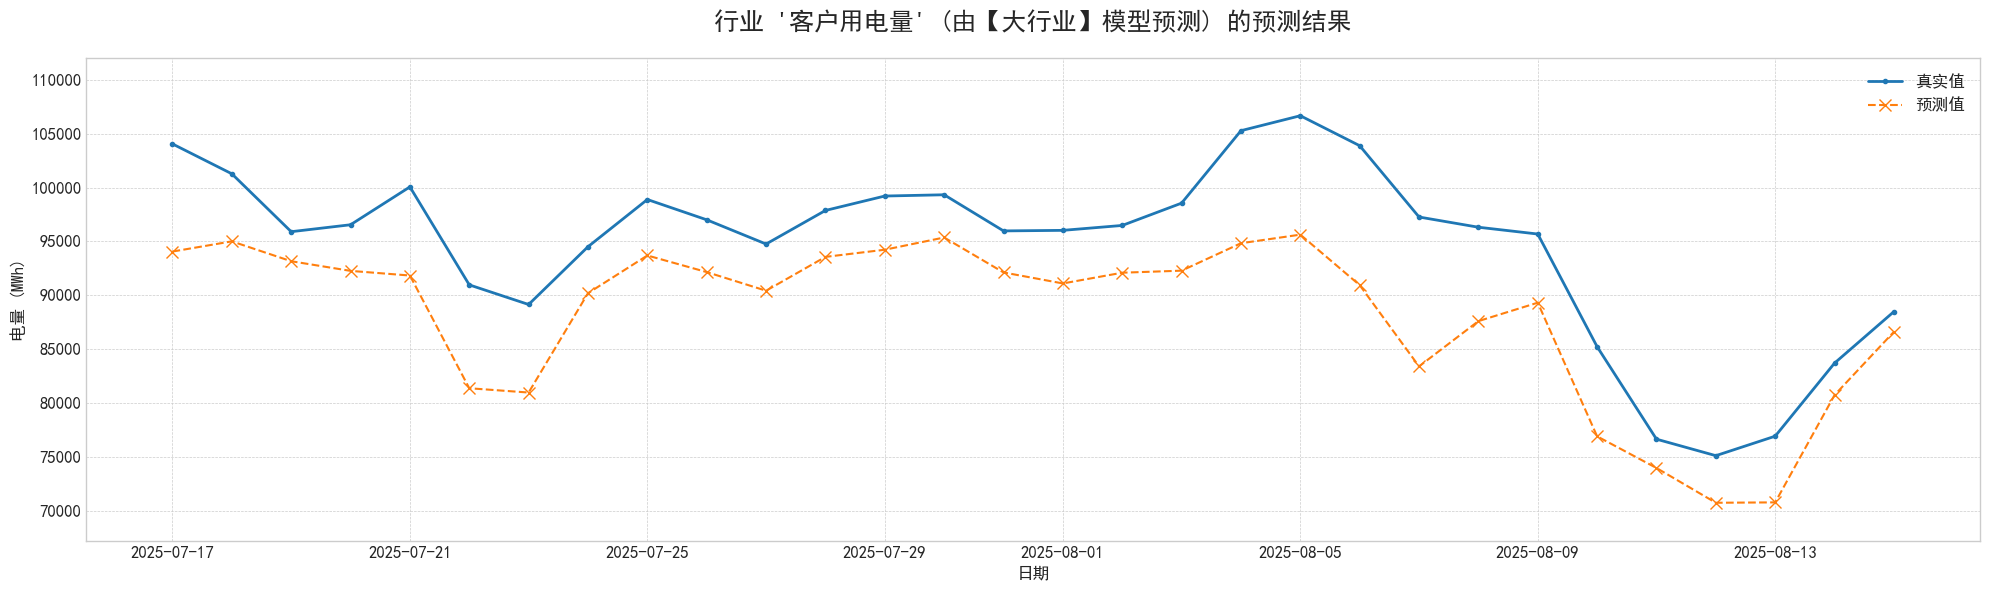

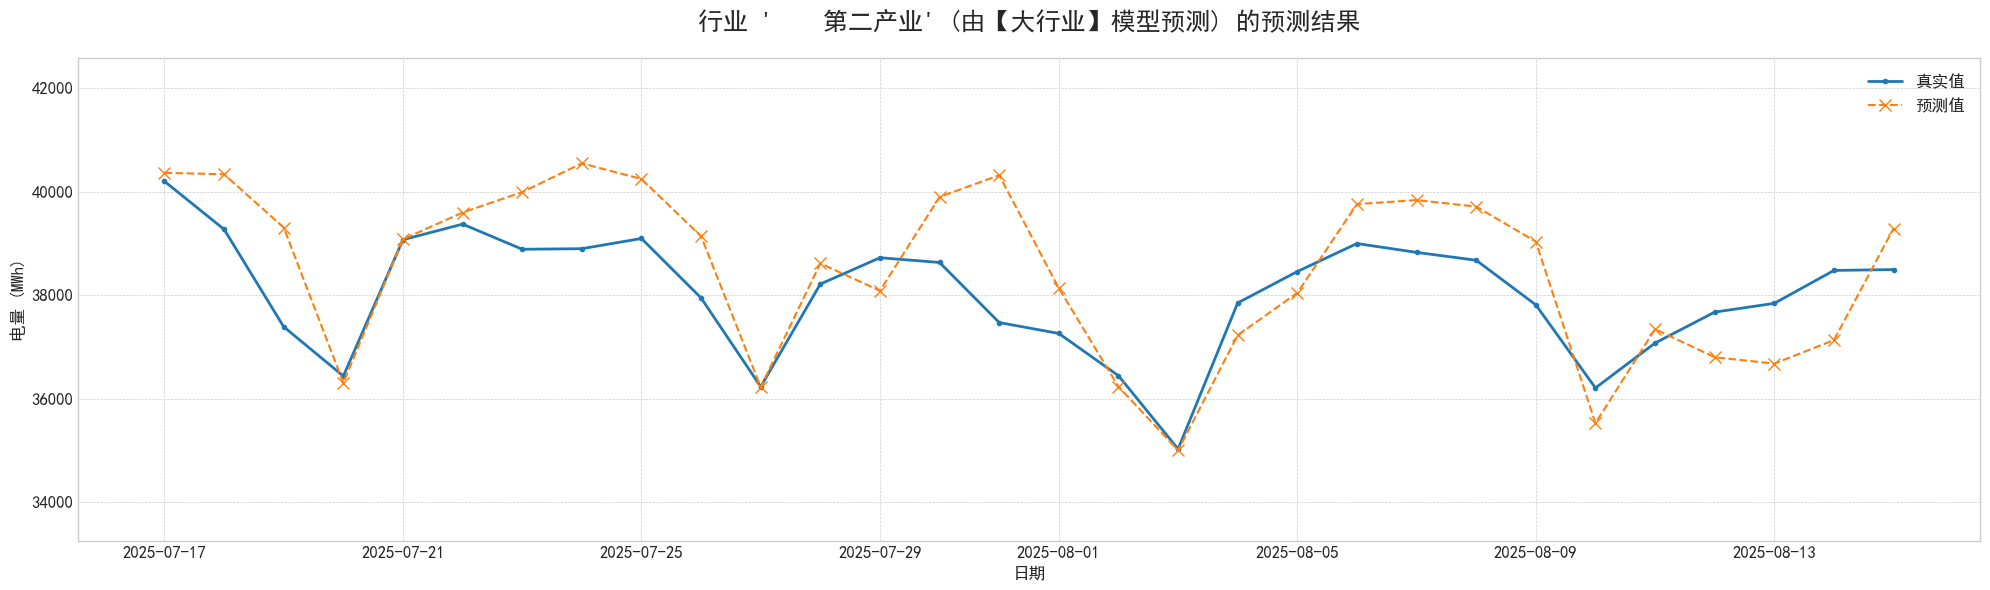

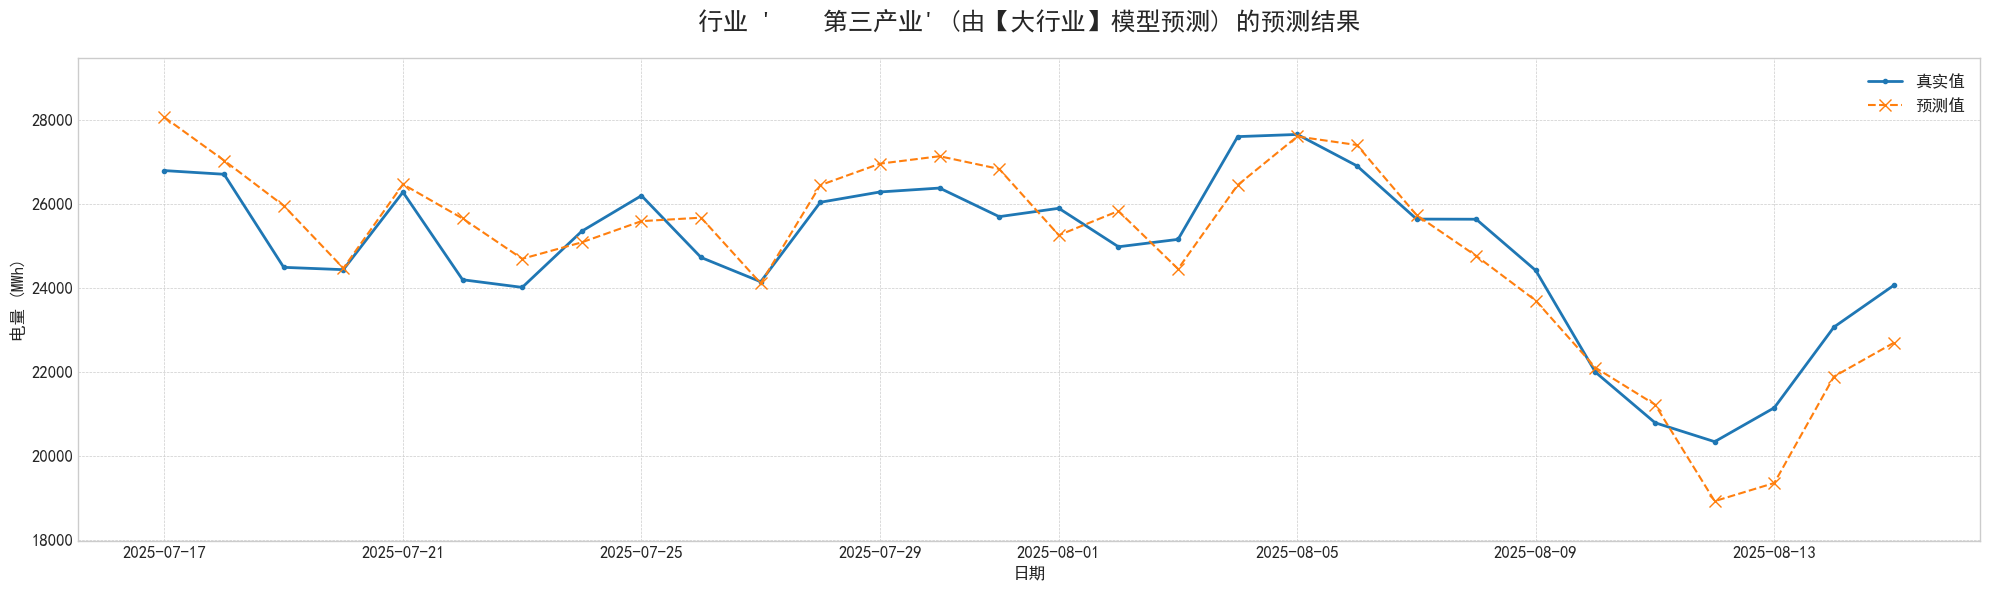

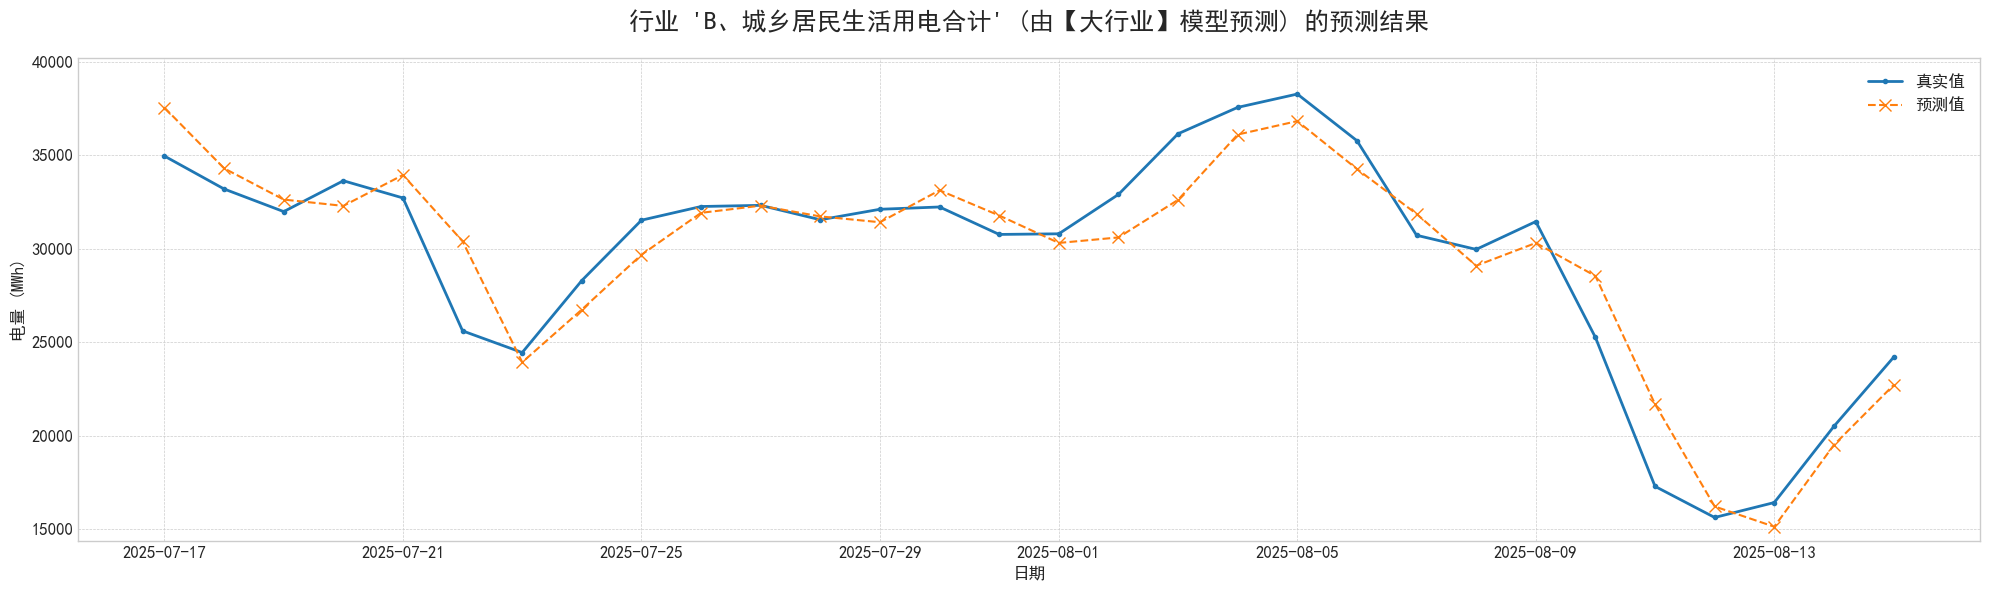

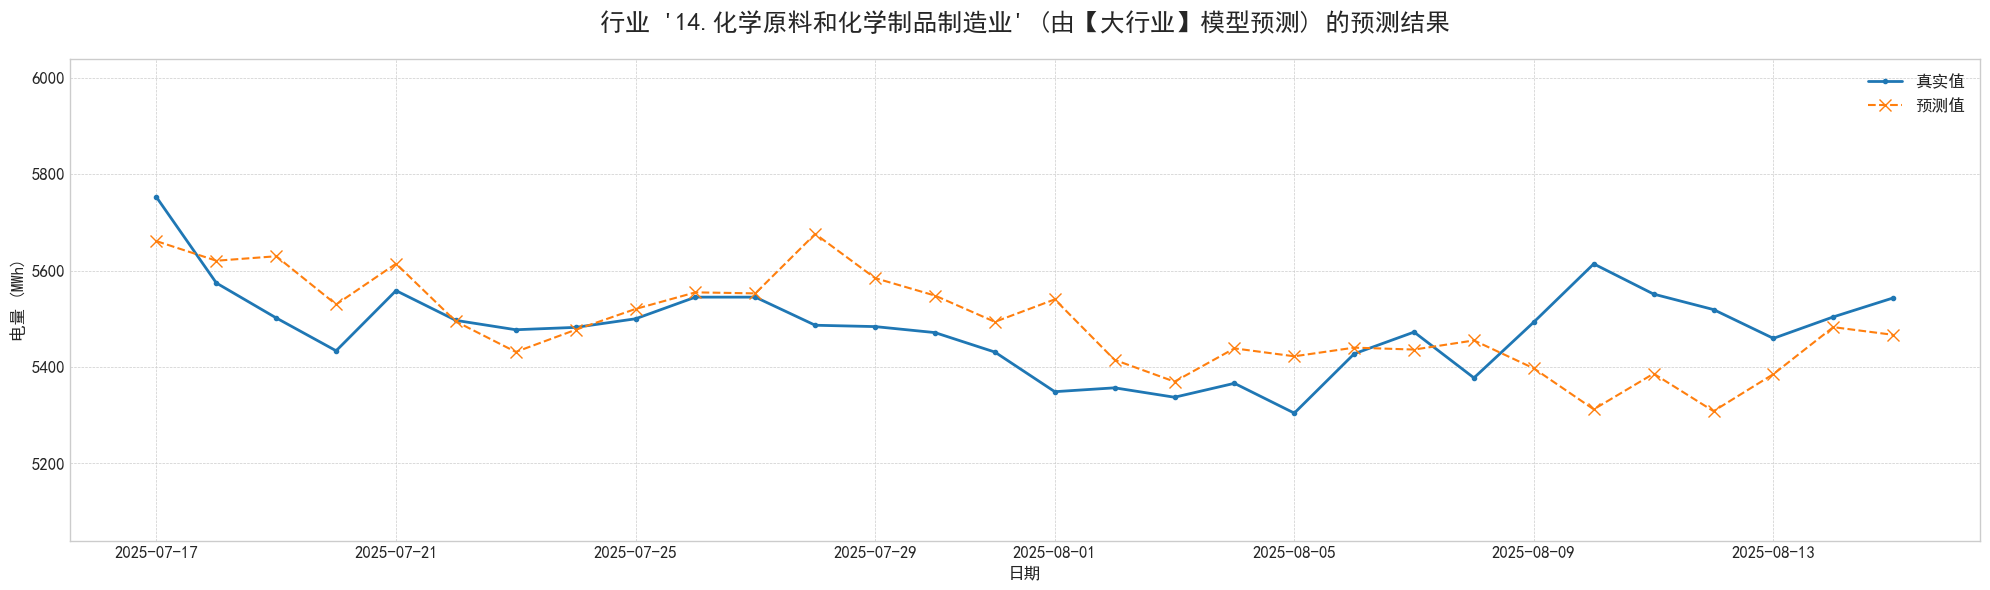

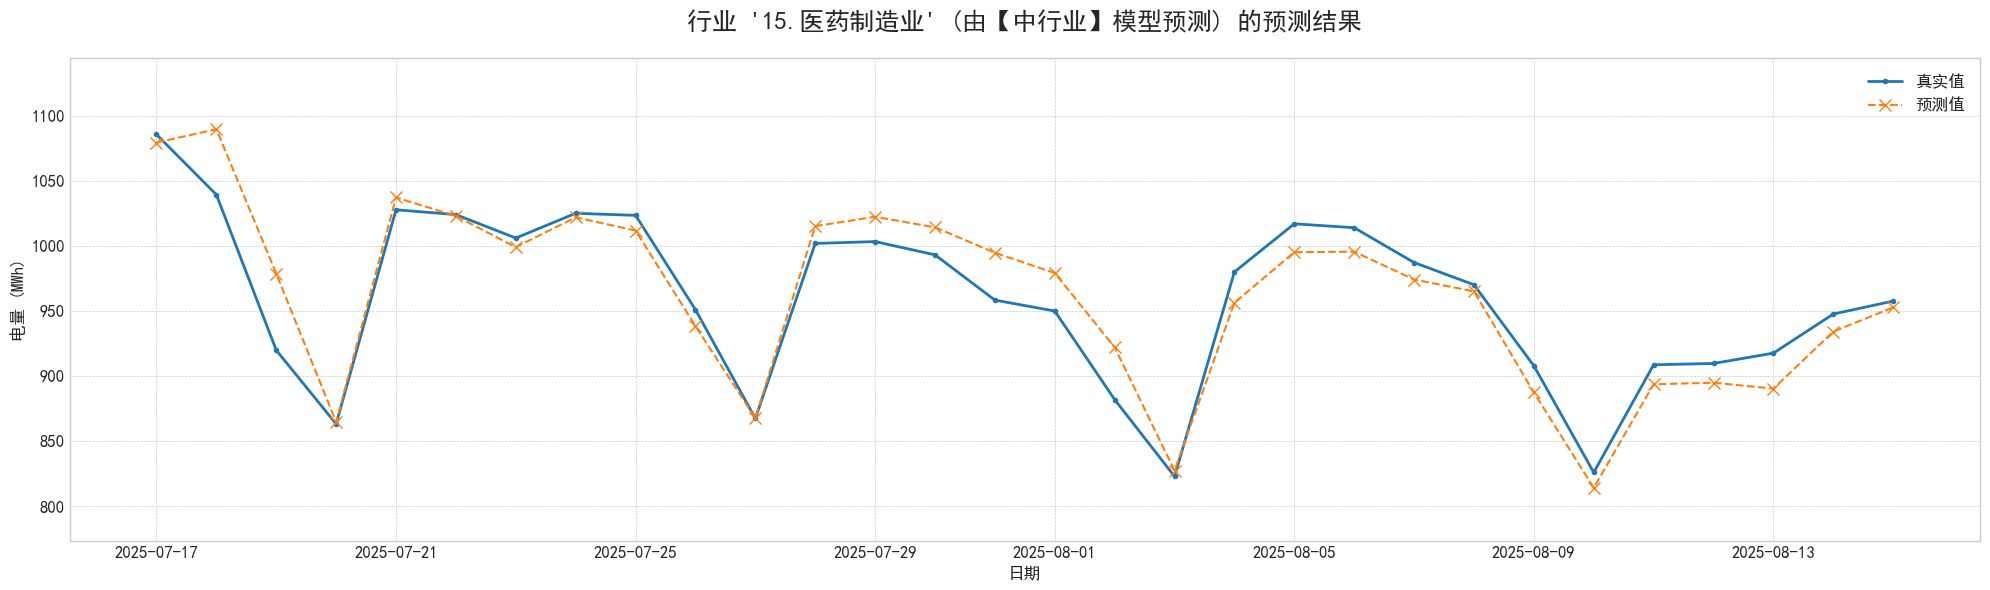

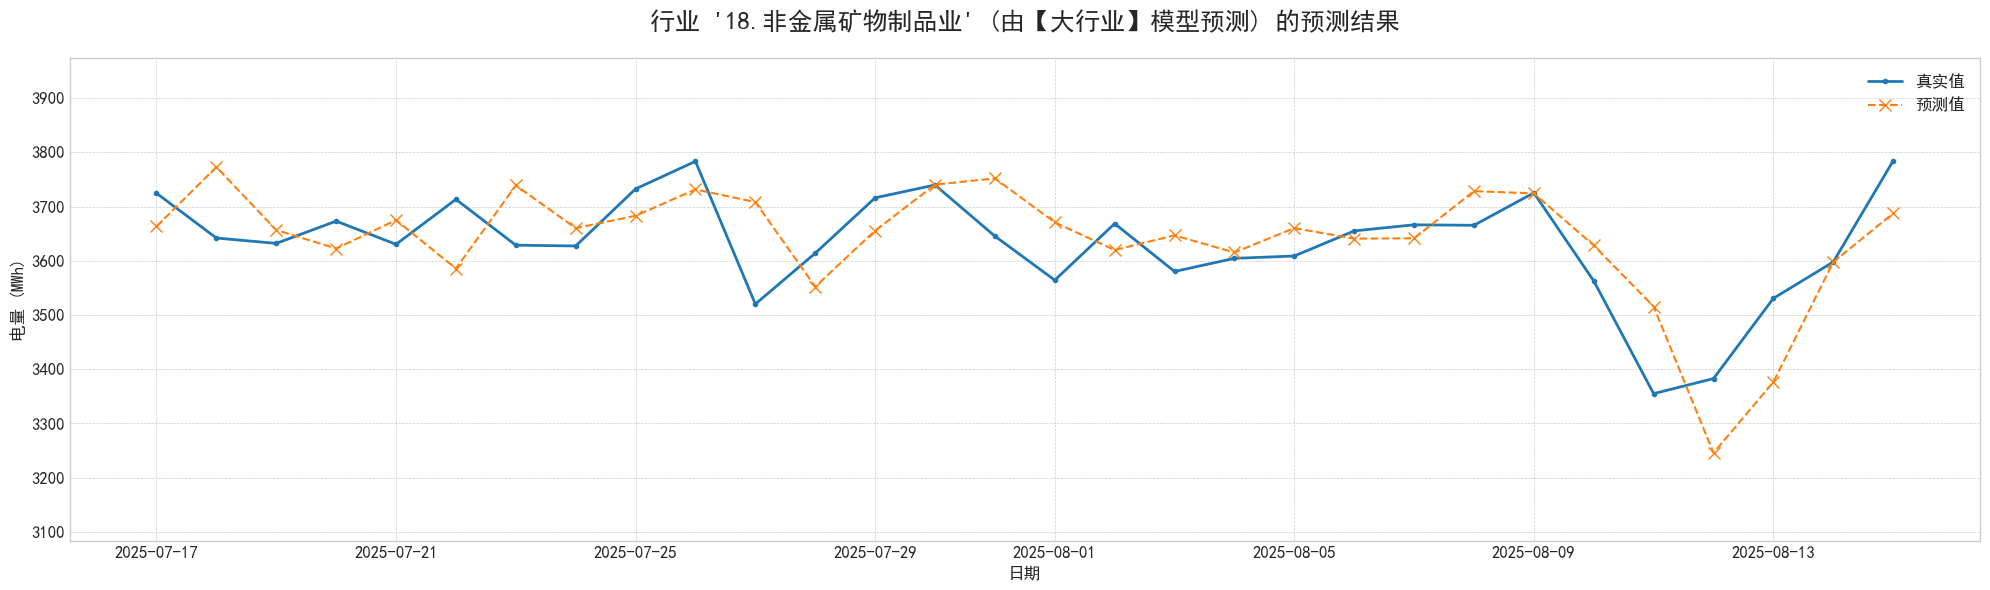

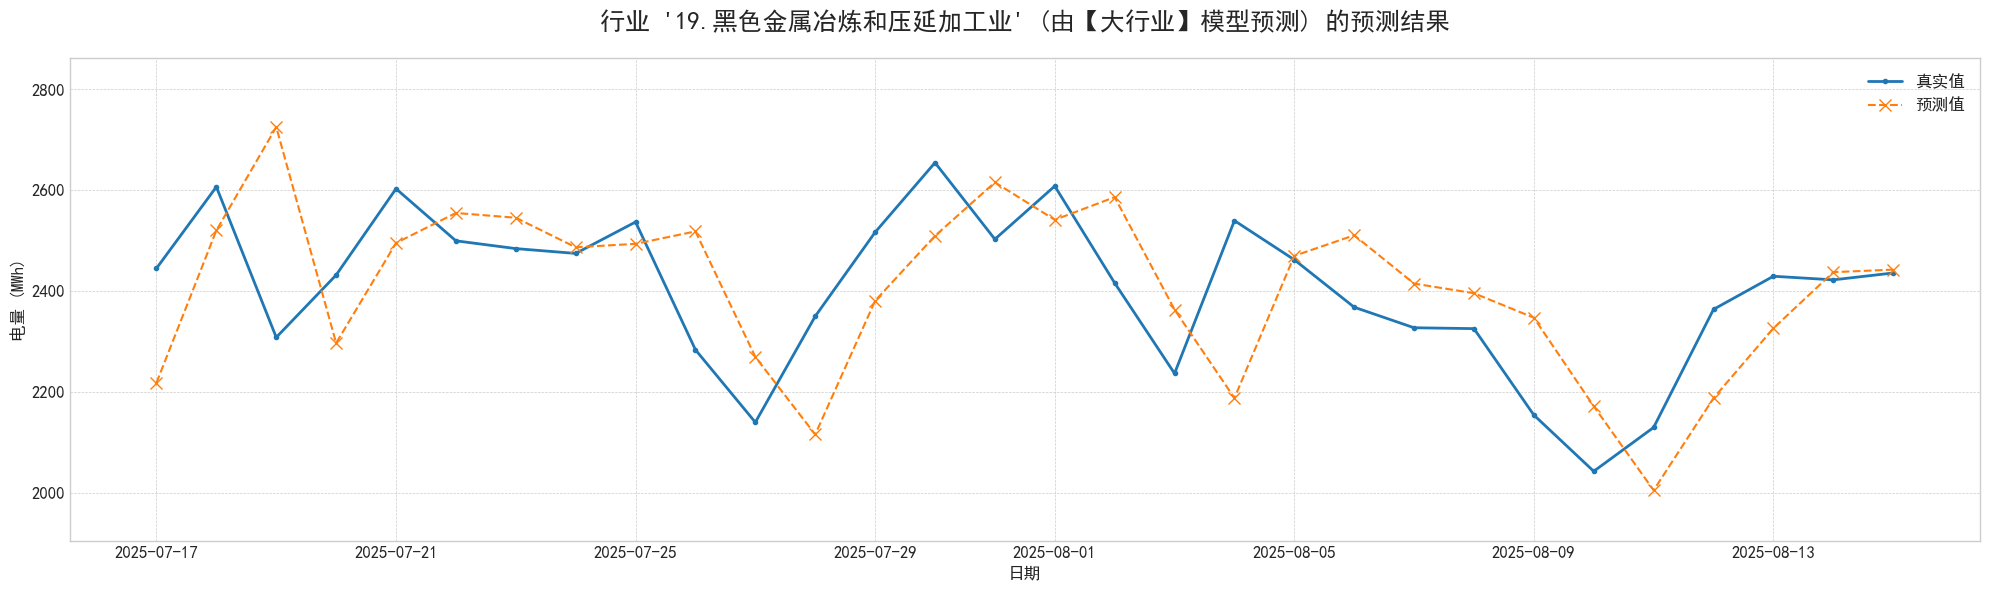

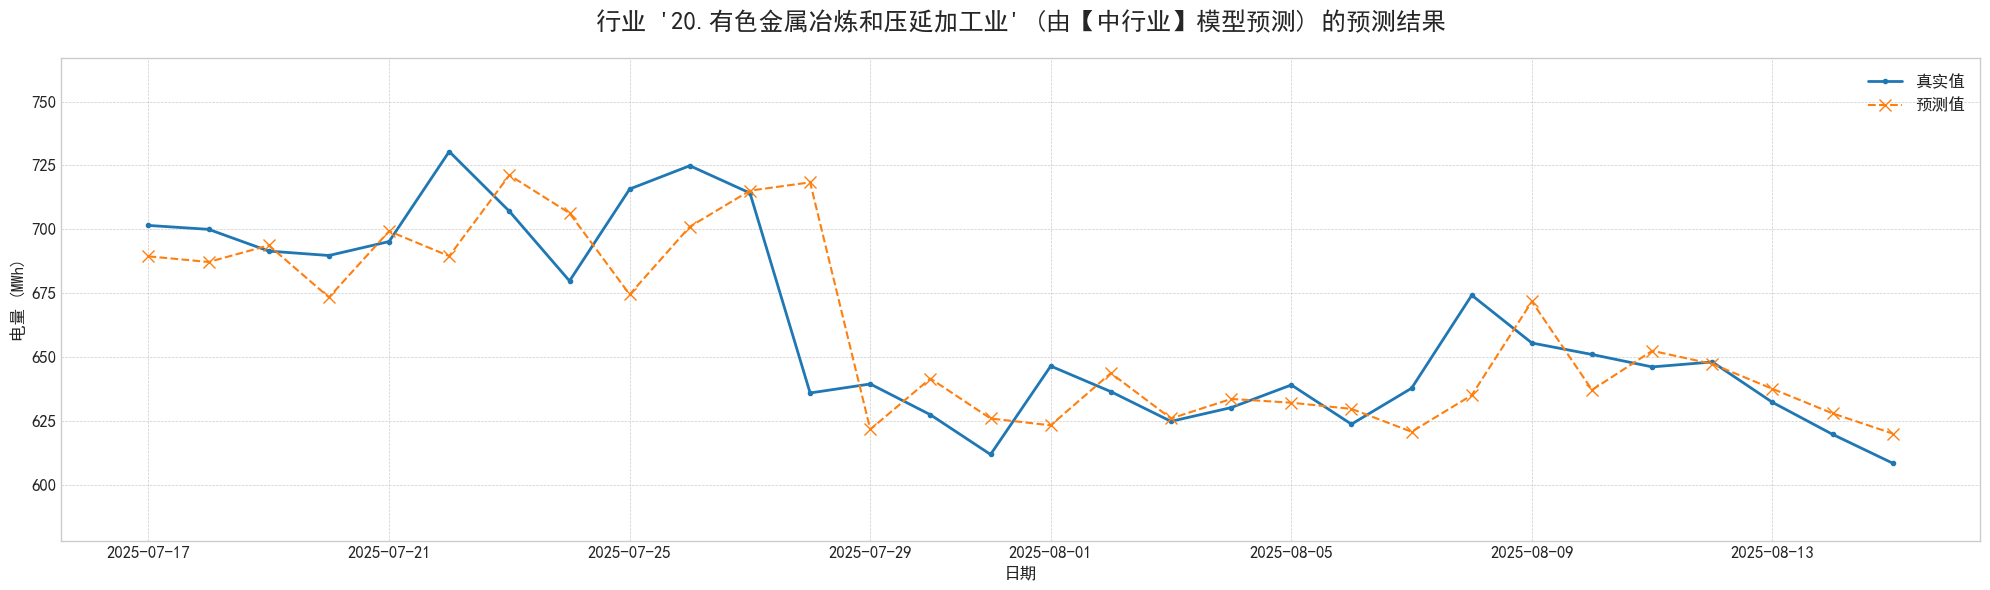

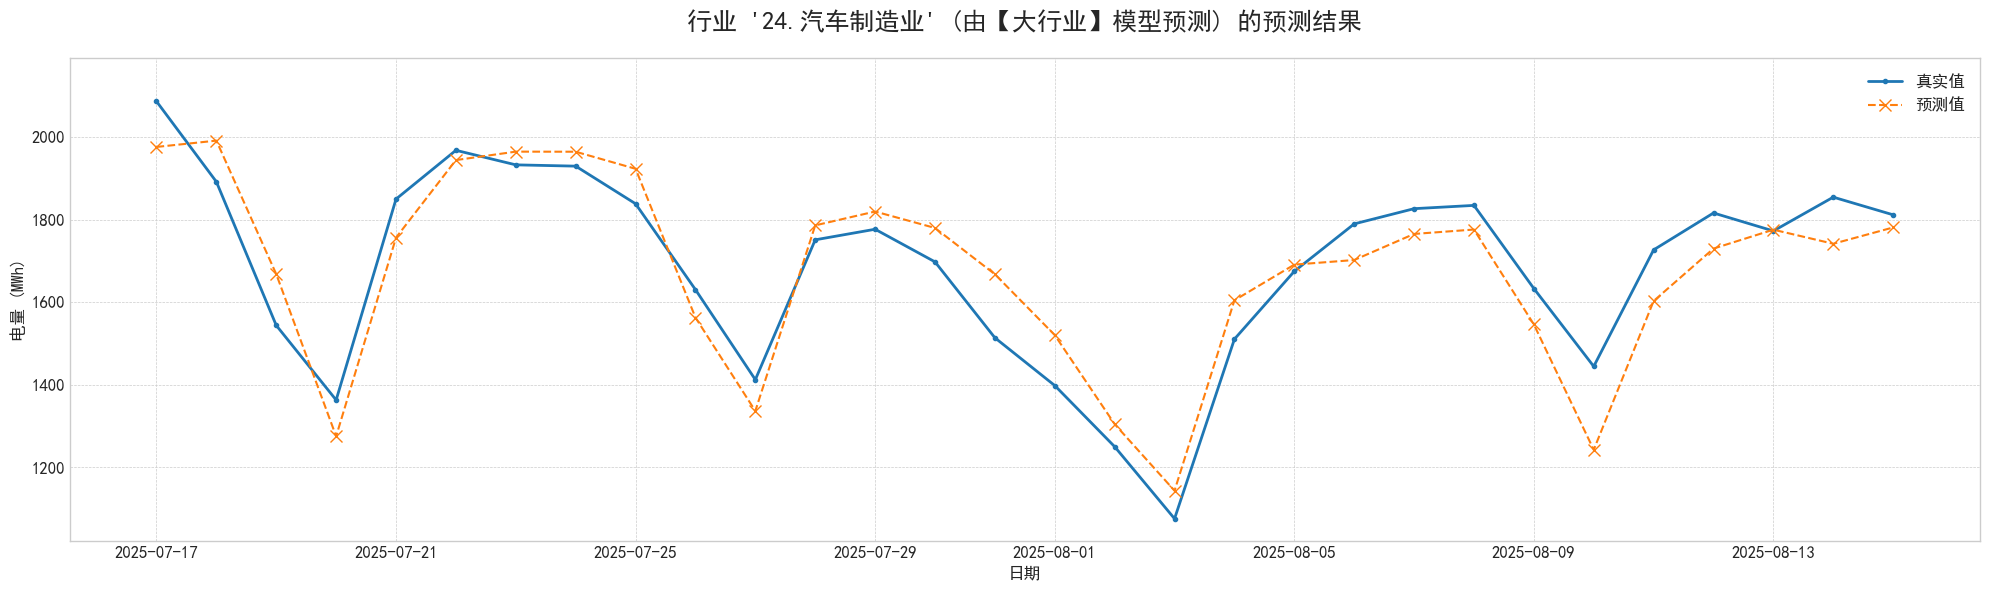

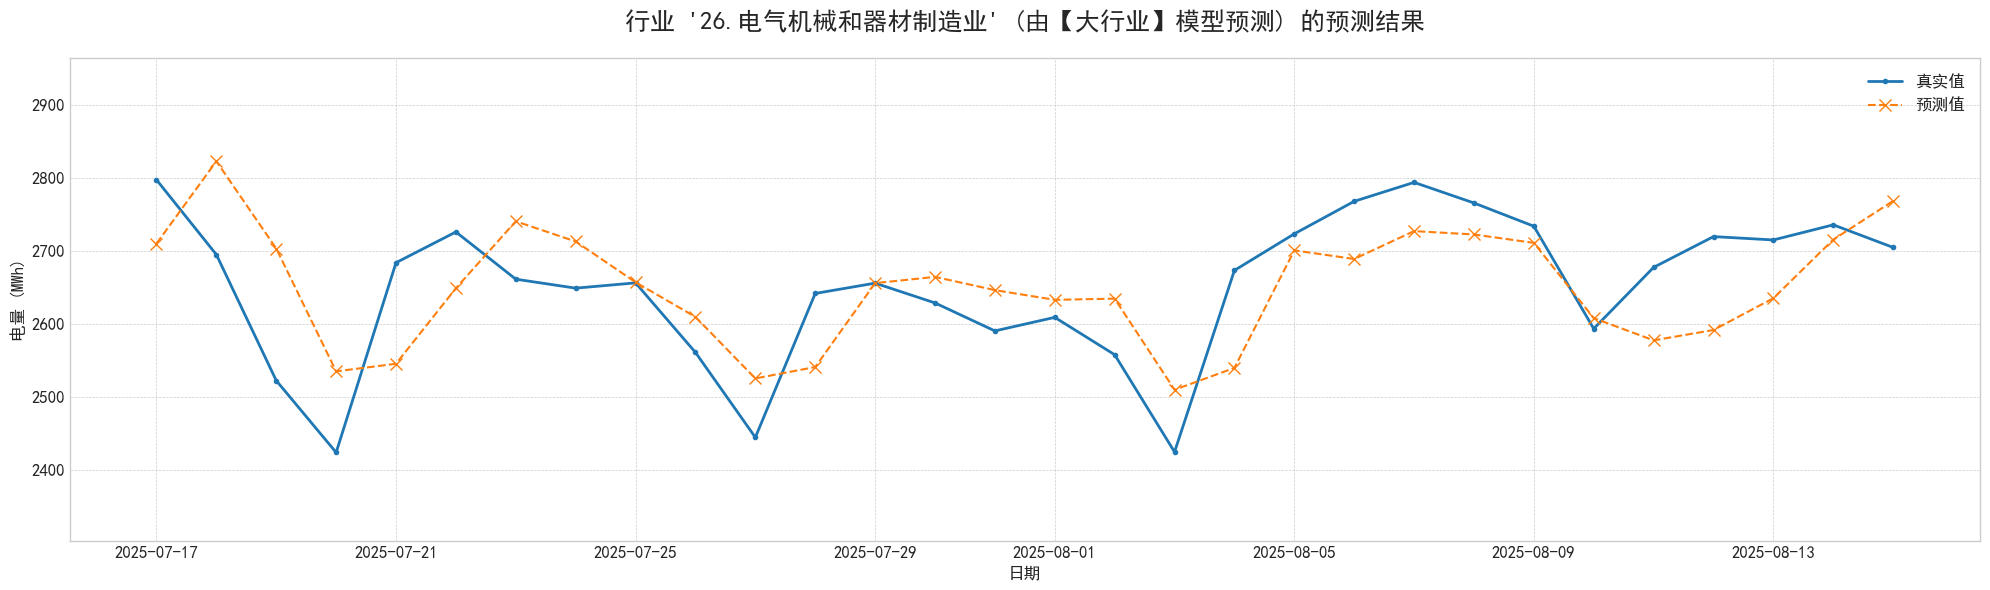

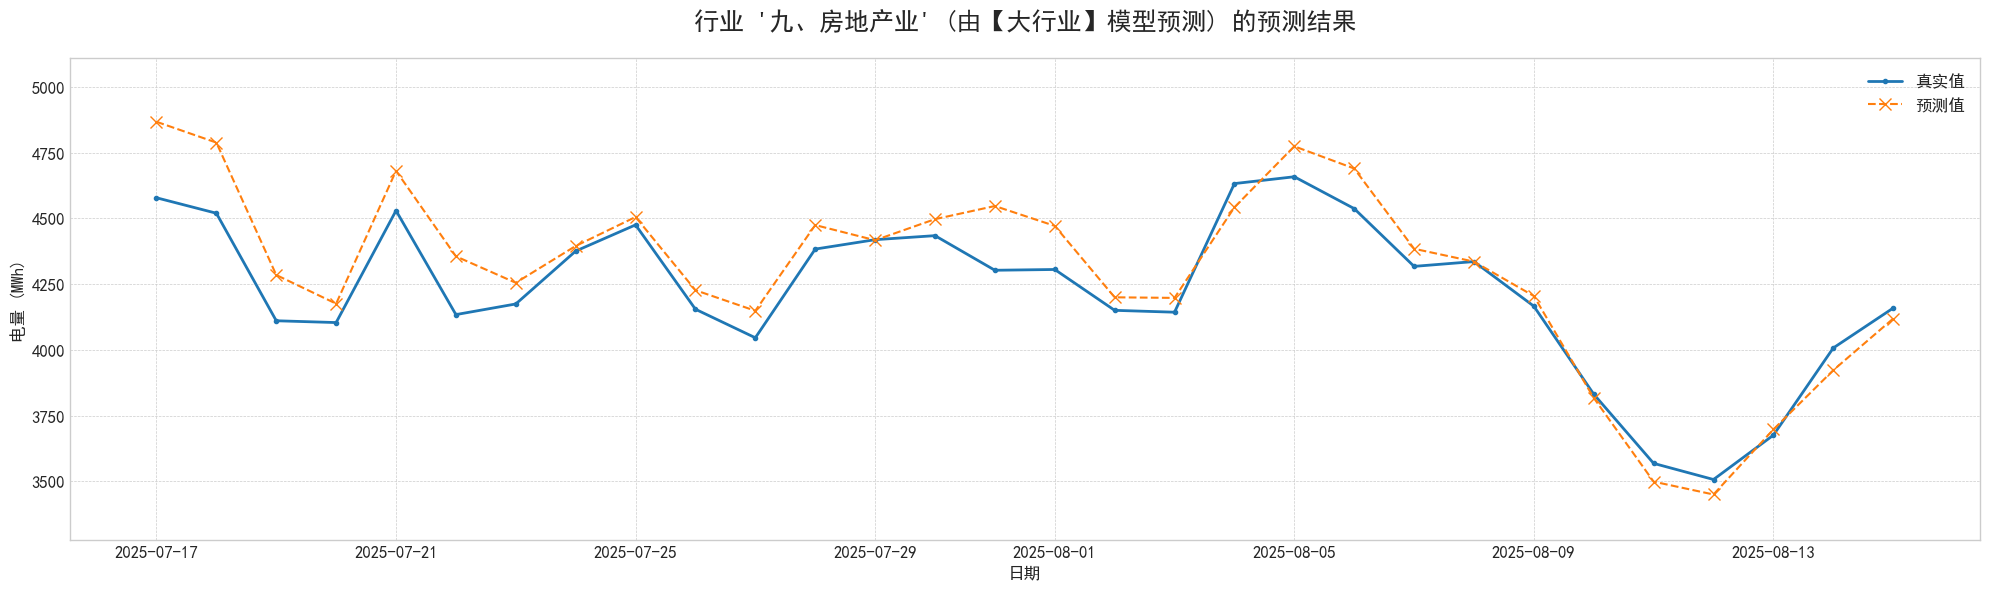

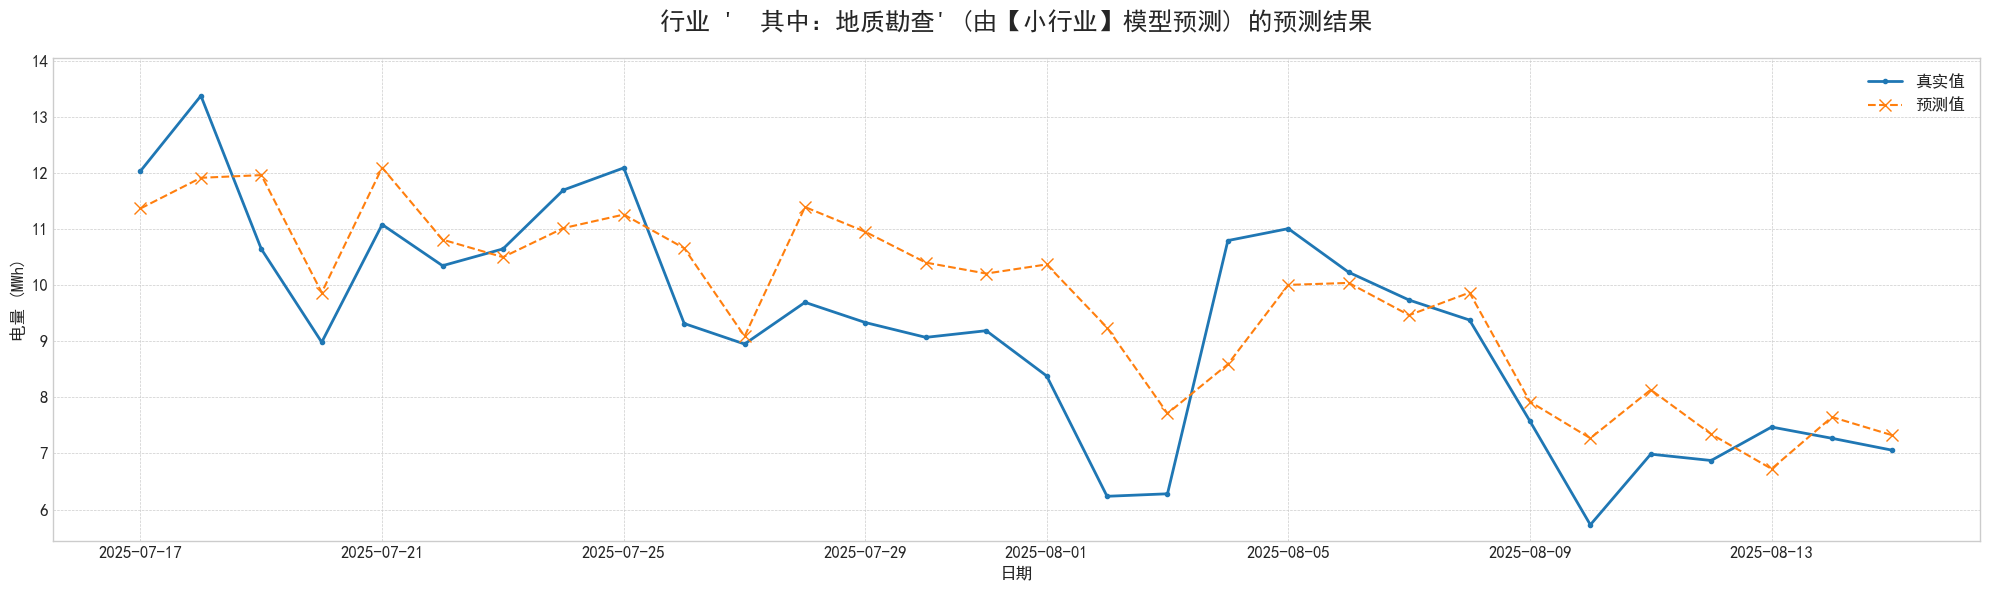

In [16]:
# --- 步骤：重点行业可视化评估 (针对分层模型结果) ---

# 确认包含所有预测结果的DataFrame 'final_test_df' 已经创建
if 'final_test_df' in locals() and not final_test_df.empty:

    # --- 1. 定义您重点关注的行业列表 ---
    key_industries = [
        "客户用电量",
        "    第二产业",
        "    第三产业",
        "B、城乡居民生活用电合计",
        "14.化学原料和化学制品制造业",
        "15.医药制造业",
        "18.非金属矿物制品业",
        "19.黑色金属冶炼和压延加工业",
        "20.有色金属冶炼和压延加工业",
        "24.汽车制造业",
        "26.电气机械和器材制造业",
        "九、房地产业",
        "  其中：地质勘查"
        # 您可以按需添加或修改这个列表
    ]
    
    # 检查您关注的行业是否都存在于测试集中
    missing_industries = [ind for ind in key_industries if ind not in final_test_df['行业名称'].unique()]
    if missing_industries:
        print(f"\n警告：以下您关注的行业在测试集中不存在，将被忽略: {missing_industries}")
        key_industries = [ind for ind in key_industries if ind in final_test_df['行业名称'].unique()]

    # --- 2. 为重点行业计算详细的评估指标 ---
    print("\n" + "="*60)
    print("      重点行业性能评估报告 (分层模型版)")
    print("="*60)
    
    metrics_list = []
    for industry in key_industries:
        subset = final_test_df[final_test_df['行业名称'] == industry]
        if subset.empty: continue
            
        true_values = subset[TARGET]
        pred_values = subset['prediction']
        
        mae = mean_absolute_error(true_values, pred_values)
        rmse = np.sqrt(mean_squared_error(true_values, pred_values))
        
        non_zero_mask = true_values != 0
        mape = np.nan if not np.any(non_zero_mask) else mean_absolute_percentage_error(true_values[non_zero_mask], pred_values[non_zero_mask])
        
        avg_load = true_values.mean()

        metrics_list.append({
            '行业名称': industry,
            '所属模型层级': subset['tier'].iloc[0], # 【新】获取该行业所属的层级
            '平均绝对误差 (MAE)': mae,
            '均方根误差 (RMSE)': rmse,
            '平均绝对百分比误差 (MAPE)': mape,
            '日均用电量': avg_load,
            'MAE占日均比': mae / avg_load if avg_load != 0 else np.nan
        })

    df_key_metrics = pd.DataFrame(metrics_list).set_index('行业名称')
    
    # 打印格式化的表格
    pd.options.display.float_format = '{:,.2f}'.format
    print(df_key_metrics.to_string(formatters={
        '平均绝对百分比误差 (MAPE)': '{:,.2%}'.format,
        'MAE占日均比': '{:,.2%}'.format
    }))
    
    # --- 3. 为每个重点行业绘制高质量的预测对比图 ---
    print("\n--- 重点行业预测结果可视化 ---")
    
    for industry in key_industries:
        subset = final_test_df[final_test_df['行业名称'] == industry]
        if subset.empty: continue
            
        fig, ax = plt.subplots(figsize=(20, 6))
        
        ax.plot(subset['date'], subset[TARGET], label='真实值', marker='.', linestyle='-', linewidth=2)
        ax.plot(subset['date'], subset['prediction'], label='预测值', marker='x', linestyle='--', markersize=8)
        
        ax.set_title(f"行业 '{industry}' (由【{subset['tier'].iloc[0]}】模型预测) 的预测结果", fontsize=18, pad=20)
        ax.set_xlabel('日期', fontsize=12)
        ax.set_ylabel('电量 (MWh)', fontsize=12)
        
        ax.legend(fontsize=12, loc='upper right')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        y_min = min(subset[TARGET].min(), subset['prediction'].min())
        y_max = max(subset[TARGET].max(), subset['prediction'].max())
        ax.set_ylim(y_min * 0.95, y_max * 1.05)
        
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

else:
    print("错误：未能找到名为 'final_test_df' 的DataFrame。请确保您已经成功运行了模型分层的训练代码块。")